<a href="https://colab.research.google.com/github/indrad123/imagecaptioning/blob/main/fin_msc_mt_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Translation Evaluation

In [2]:
!pip install datasets
!pip install nusacrowd
!pip install evaluate
!pip install sentencepiece
!pip install sacremoses
!pip install transformers
!pip install rouge_score
!pip install dl-translate
!pip install googletrans==3.1.0a0
!pip install dl-translate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.1/542.1 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 18.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.9/64.9 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 27.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
  Attempting uninstall: requests
    Found existing installation: requests 2.31.0
    Uninstalling requests-2.31.0:
      Successfully uninstalled requests-2.31.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.31.0, but you have requests 2.32.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 384.2/384.2 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s e

In [6]:
import torch
from torch.utils.data import DataLoader
from transformers import MarianTokenizer, MarianMTModel, AutoTokenizer, AutoModelForSeq2SeqLM
from datasets import load_dataset, Dataset, DatasetDict
import evaluate
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import h5py
import dl_translate as dlt
from googletrans import Translator
import nltk
from tqdm import tqdm

nltk.download('punkt')

# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")



[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [7]:
# Function to load and preprocess the dataset
def load_and_preprocess_dataset(dataset_name):
    dataset = load_dataset(dataset_name, trust_remote_code=True)
    return dataset

def preprocess_function(examples, tokenizer=None, src_lang=None):
    if tokenizer and src_lang:
        tokenizer.src_lang = src_lang
        model_inputs = tokenizer(examples['src'], text_target=examples['tgt'], truncation=True, padding='max_length', max_length=512, return_tensors='pt')
        return model_inputs
    else:
        return {"src": examples["src"], "tgt": examples["tgt"]}

def get_dataloader(encoded_dataset, batch_size=16, use_translate_func=False):
    def collate_fn(batch):
        if use_translate_func:
            src_texts = [item['src'] for item in batch]
            tgt_texts = [item['tgt'] for item in batch]
            return {'src': src_texts, 'tgt': tgt_texts}
        else:
            result = {}
            for key in batch[0]:
                if isinstance(batch[0][key], str):
                    result[key] = [item[key] for item in batch]
                else:
                    result[key] = torch.stack([torch.tensor(item[key]) for item in batch])
            return result

    dataloader = DataLoader(encoded_dataset, batch_size=batch_size, collate_fn=collate_fn)
    return dataloader

def generate_predictions_hf(dataloader, model, tokenizer, src_lang):
    predictions, actuals = [], []

    for batch in tqdm(dataloader, desc="Generating Predictions with HF Model"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        if src_lang and hasattr(tokenizer, 'src_lang'):
            tokenizer.src_lang = src_lang

        with torch.no_grad():
            generated_tokens = model.generate(input_ids, attention_mask=attention_mask, max_length=512)

        preds = tokenizer.batch_decode(generated_tokens, skip_special_tokens=True)
        actual_texts = tokenizer.batch_decode(labels, skip_special_tokens=True)
        predictions.extend(preds)
        actuals.extend(actual_texts)

    return predictions, actuals

def generate_predictions_translate(dataloader, translate_func):
    predictions, actuals = [], []

    for batch in tqdm(dataloader, desc="Generating Predictions with Translation Function"):
        src_texts = batch['src']
        actual_texts = batch['tgt']
        preds = [translate_func(text) for text in src_texts]
        predictions.extend(preds)
        actuals.extend(actual_texts)

    return predictions, actuals

def load_model_and_tokenizer(model_name, model_type):
    model_tokenizer_map = {
        "marian": (MarianTokenizer, MarianMTModel),
        "mt5": (AutoTokenizer, AutoModelForSeq2SeqLM)
    }
    if model_type in model_tokenizer_map:
        tokenizer_class, model_class = model_tokenizer_map[model_type]
        tokenizer = tokenizer_class.from_pretrained(model_name)
        model = model_class.from_pretrained(model_name)
        model.to(device)

        if torch.cuda.device_count() > 1:
            model = torch.nn.DataParallel(model)

        return model, tokenizer
    else:
        return None, None

def evaluate_model(predictions, actuals, model_name):
    # Load the metrics
    bleu_metric = evaluate.load('bleu')
    rouge_metric = evaluate.load('rouge')
    meteor_metric = evaluate.load('meteor')

    # Ensure both predictions and actuals are lists of strings
    predictions = [" ".join(nltk.word_tokenize(pred)) for pred in predictions]
    actuals = [" ".join(nltk.word_tokenize(actual)) for actual in actuals]

    # Prepare data for metrics
    predictions_for_metrics = predictions  # List of strings
    actuals_for_metrics = actuals  # List of strings

    # Debug: Print predictions and actuals
    print(f"Predictions: {predictions_for_metrics[:5]}")
    print(f"Actuals: {actuals_for_metrics[:5]}")

    # Compute the metrics
    bleu_score = bleu_metric.compute(predictions=predictions_for_metrics, references=[[ref] for ref in actuals_for_metrics])
    rouge_score = rouge_metric.compute(predictions=predictions_for_metrics, references=[[ref] for ref in actuals_for_metrics])
    meteor_score = meteor_metric.compute(predictions=predictions_for_metrics, references=[[ref] for ref in actuals_for_metrics])

    # Debug: Print metric results
    print(f"BLEU Score: {bleu_score}")
    print(f"ROUGE Score: {rouge_score}")
    print(f"Meteor Score: {meteor_score}")

    # Extract relevant scores
    bleu_score_value = bleu_score['bleu']
    rouge_score_value = rouge_score['rouge1']["fmeasure"] if isinstance(rouge_score['rouge1'], dict) else rouge_score['rouge1']  # Check if rouge1 is a dictionary
    meteor_score_value = meteor_score['meteor']

    # Create a DataFrame with the results
    df_eval = pd.DataFrame({
        "model": [model_name],
        "bleu_score": [bleu_score_value],
        "rouge_score": [rouge_score_value],
        "meteor_score": [meteor_score_value]
    })

    return df_eval

def translate_m2m100(text_en):
    mt = dlt.TranslationModel("facebook/m2m100_418M")
    translation_id = mt.translate(text_en, source=dlt.lang.ENGLISH, target=dlt.lang.INDONESIAN)
    return translation_id

def translate_mbart50(text_en):
    mt = dlt.TranslationModel("facebook/mbart-large-50-many-to-many-mmt")
    translation_id = mt.translate(text_en, source=dlt.lang.ENGLISH, target=dlt.lang.INDONESIAN)
    return translation_id

def translate_nllb200(text_en):
    mt = dlt.TranslationModel("facebook/nllb-200-distilled-600M")
    translation_id = mt.translate(text_en, source=dlt.lang.ENGLISH, target=dlt.lang.INDONESIAN)
    return translation_id

def translate_google_text(text):
    try:
        translator = Translator()
        translated = translator.translate(text, src='en', dest='id').text
        return translated
    except Exception as e:
        print(f"Error: {e}")
        return ''



In [8]:
# Initialize an empty DataFrame to store results
df_eval = pd.DataFrame()

# Define model configurations
models_config = [
    {"model_name": "Helsinki-NLP/opus-mt-en-id", "model_type": "marian"},
    {"model_name": "acul3/mt5-translate-en-id", "model_type": "mt5"},
    {"model_name": "dl_translate_m2m100", "model_type": "dl_translate", "translate_func": translate_m2m100},
    {"model_name": "dl_translate_mbart50", "model_type": "dl_translate", "translate_func": translate_mbart50},
    {"model_name": "dl_translate_nllb200", "model_type": "dl_translate", "translate_func": translate_nllb200},
    {"model_name": "google_translate", "model_type": "googletrans", "translate_func": translate_google_text}
]

dataset_name = "SEACrowd/indo_general_mt_en_id"
dataset = load_and_preprocess_dataset(dataset_name)

# Directory to save intermediate results
checkpoint_dir = "/content/drive/MyDrive/Datasets/EvaluationTranslation"
os.makedirs(checkpoint_dir, exist_ok=True)

# Process each model configuration
for config in models_config:
    model_name = config['model_name']
    model_type = config['model_type']
    translate_func = config.get('translate_func')
    model, tokenizer = load_model_and_tokenizer(model_name, model_type)

    # Set language parameters based on model type
    if model_type not in ["dl_translate", "googletrans"]:
        src_lang = "en"
        tgt_lang = "id"
    else:
        src_lang = None
        tgt_lang = None

    # Process in chunks and save intermediate results
    chunk_size = 50
    num_chunks = (len(dataset["test"]) + chunk_size - 1) // chunk_size  # Calculate number of chunks
    for i in tqdm(range(num_chunks), desc=f"Processing chunks for {model_name}"):
        start_idx = i * chunk_size
        end_idx = min((i + 1) * chunk_size, len(dataset["test"]))  # Ensure end index does not exceed dataset size
        checkpoint_path = os.path.join(checkpoint_dir, model_name.replace('/', '_'), f"chunk_{i}.h5")

        # Ensure the directory for this model exists
        os.makedirs(os.path.dirname(checkpoint_path), exist_ok=True)

        # Skip already processed chunks
        if os.path.exists(checkpoint_path):
            print(f"Skipping chunk {i} for model {model_name}")
            continue

        chunk = dataset["test"].select(range(start_idx, end_idx))

        if model_type not in ["dl_translate", "googletrans"]:
            encoded_chunk = chunk.map(lambda x: preprocess_function(x, tokenizer, src_lang=src_lang), batched=True)
            dataloader = get_dataloader(encoded_chunk, use_translate_func=False)
            predictions, actuals = generate_predictions_hf(dataloader, model, tokenizer, src_lang)
        else:
            encoded_chunk = chunk.map(lambda x: preprocess_function(x), batched=True)
            dataloader = get_dataloader(encoded_chunk, use_translate_func=True)
            predictions, actuals = generate_predictions_translate(dataloader, translate_func)

        # Encode predictions and actuals as UTF-8
        predictions = [pred.encode('utf-8') for pred in predictions]
        actuals = [act.encode('utf-8') for act in actuals]

        # Save predictions and actuals
        with h5py.File(checkpoint_path, 'w') as f:
            f.create_dataset('predictions', data=np.array(predictions, dtype='S'))
            f.create_dataset('actuals', data=np.array(actuals, dtype='S'))

# Combine all results for evaluation
#for config in models_config:
#    model_name = config['model_name']

#    all_predictions, all_actuals = [], []
#    for i in range(num_chunks):
#        checkpoint_path = os.path.join(checkpoint_dir, model_name.replace('/', '_'), f"chunk_{i}.h5")
#        if os.path.exists(checkpoint_path):
#            with h5py.File(checkpoint_path, 'r') as f:
#                all_predictions.extend([pred.decode('utf-8') for pred in f['predictions']])
#                all_actuals.extend([act.decode('utf-8') for act in f['actuals']])

#    eval_results = evaluate_model(all_predictions, all_actuals, model_name)
#    df_eval = pd.concat([df_eval, eval_results], ignore_index=True)

# Save the evaluation results to a local HDF5 file
#df_eval.to_hdf('/content/drive/MyDrive/Datasets/EvaluationTranslation/evaluation_results.h5', key='df_eval', mode='w')

# Save the translated dataset to a local HDF5 file
#translated_dataset_dict = DatasetDict({
#    'test': Dataset.from_pandas(pd.DataFrame({'predictions': all_predictions, 'actuals': all_actuals}))
#})
#translated_dataset_dict.save_to_disk('/content/drive/MyDrive/Datasets/EvaluationTranslation/translated_dataset')

#print("Translated dataset and evaluation results saved successfully.")

# Print the updated DataFrame
#print(df_eval)




Processing chunks for Helsinki-NLP/opus-mt-en-id: 100%|██████████| 40/40 [00:00<00:00, 1657.40it/s]


Skipping chunk 0 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 1 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 2 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 3 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 4 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 5 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 6 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 7 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 8 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 9 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 10 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 11 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 12 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 13 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 14 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 15 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 16 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 17 for model Helsinki-NLP/opus-mt-en-id
Skipping chunk 18 fo

tokenizer_config.json:   0%|          | 0.00/376 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/4.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/65.0 [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:560: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


pytorch_model.bin:   0%|          | 0.00/4.92G [00:00<?, ?B/s]

Processing chunks for acul3/mt5-translate-en-id:   0%|          | 0/40 [00:00<?, ?it/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with HF Model: 100%|██████████| 4/4 [00:14<00:00,  3.67s/it]
Processing chunks for acul3/mt5-translate-en-id:   2%|▎         | 1/40 [00:14<09:39, 14.85s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with HF Model: 100%|██████████| 4/4 [00:11<00:00,  2.91s/it]
Processing chunks for acul3/mt5-translate-en-id:   5%|▌         | 2/40 [00:26<08:15, 13.03s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with HF Model: 100%|██████████| 4/4 [00:11<00:00,  2.93s/it]
Processing chunks for acul3/mt5-translate-en-id:   8%|▊         | 3/40 [00:38<07:42, 12.50s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  10%|█         | 4/40 [01:12<12:29, 20.82s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  12%|█▎        | 5/40 [01:25<10:41, 18.32s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  15%|█▌        | 6/40 [02:01<13:38, 24.06s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  18%|█▊        | 7/40 [02:15<11:26, 20.80s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  20%|██        | 8/40 [02:49<13:19, 24.98s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  22%|██▎       | 9/40 [03:06<11:42, 22.67s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  25%|██▌       | 10/40 [03:41<13:14, 26.48s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  28%|██▊       | 11/40 [03:54<10:47, 22.32s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  30%|███       | 12/40 [04:09<09:21, 20.07s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  32%|███▎      | 13/40 [04:42<10:46, 23.95s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  35%|███▌      | 14/40 [04:58<09:19, 21.53s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  38%|███▊      | 15/40 [05:14<08:15, 19.84s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  40%|████      | 16/40 [05:28<07:14, 18.10s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  42%|████▎     | 17/40 [05:47<07:02, 18.39s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  45%|████▌     | 18/40 [06:20<08:19, 22.69s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  48%|████▊     | 19/40 [06:53<09:06, 26.01s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  50%|█████     | 20/40 [07:27<09:26, 28.32s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  52%|█████▎    | 21/40 [07:42<07:38, 24.15s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  55%|█████▌    | 22/40 [08:35<09:53, 32.96s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  57%|█████▊    | 23/40 [08:51<07:51, 27.73s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  60%|██████    | 24/40 [09:25<07:57, 29.87s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  62%|██████▎   | 25/40 [09:43<06:32, 26.20s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  65%|██████▌   | 26/40 [09:58<05:21, 22.94s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  68%|██████▊   | 27/40 [10:19<04:48, 22.20s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  70%|███████   | 28/40 [11:01<05:37, 28.09s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  72%|███████▎  | 29/40 [11:13<04:18, 23.49s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  75%|███████▌  | 30/40 [11:37<03:55, 23.58s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  78%|███████▊  | 31/40 [11:50<03:02, 20.29s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  80%|████████  | 32/40 [12:07<02:34, 19.34s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  82%|████████▎ | 33/40 [12:20<02:02, 17.51s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  85%|████████▌ | 34/40 [12:38<01:45, 17.64s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  88%|████████▊ | 35/40 [12:53<01:23, 16.76s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  90%|█████████ | 36/40 [13:29<01:30, 22.63s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  92%|█████████▎| 37/40 [14:05<01:19, 26.51s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  95%|█████████▌| 38/40 [14:18<00:45, 22.53s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for acul3/mt5-translate-en-id:  98%|█████████▊| 39/40 [14:33<00:20, 20.18s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Processing chunks for dl_translate_m2m100:   0%|          | 0/40 [00:00<?, ?it/s]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/298 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/3.71M [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/1.14k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.94G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/233 [00:00<?, ?B/s]


Generating Predictions with Translation Function:  25%|██▌       | 1/4 [01:02<03:07, 62.46s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:55<01:54, 57.20s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:45<00:53, 53.57s/it]
Processing chunks for dl_translate_m2m100:   2%|▎         | 1/40 [02:51<1:51:36, 171.71s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:49<02:29, 49.78s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:40<01:40, 50.26s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:30<00:50, 50.01s/it]
Processing chunks for dl_translate_m2m100:   5%|▌         | 2/40 [05:27<1:42:56, 162.54s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:49<02:28, 49.44s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:38<01:38, 49.03s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:30<00:50, 50.47s/it]
Processing chunks for dl_translate_m2m100:   8%|▊         | 3/40 [08:04<1:38:30, 159.74s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:48<02:26, 48.88s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:41<01:41, 51.00s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:33<00:51, 51.66s/it]
Processing chunks for dl_translate_m2m100:  10%|█         | 4/40 [10:44<1:35:53, 159.82s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:36, 52.07s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:44<01:44, 52.02s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:51, 51.66s/it]
Processing chunks for dl_translate_m2m100:  12%|█▎        | 5/40 [13:25<1:33:37, 160.51s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:37, 52.43s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:43<01:43, 51.77s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:51, 51.77s/it]
Processing chunks for dl_translate_m2m100:  15%|█▌        | 6/40 [16:07<1:31:15, 161.04s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:50<02:32, 50.88s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:41<01:41, 50.57s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:33<00:51, 51.30s/it]
Processing chunks for dl_translate_m2m100:  18%|█▊        | 7/40 [18:47<1:28:15, 160.47s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:49<02:28, 49.65s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:40<01:40, 50.28s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:32<00:51, 51.08s/it]
Processing chunks for dl_translate_m2m100:  20%|██        | 8/40 [21:26<1:25:18, 159.94s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:36, 52.23s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:45<01:45, 52.78s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:51, 51.55s/it]
Processing chunks for dl_translate_m2m100:  22%|██▎       | 9/40 [24:07<1:22:56, 160.54s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:49<02:29, 49.70s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:40<01:40, 50.47s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:32<00:51, 51.27s/it]
Processing chunks for dl_translate_m2m100:  25%|██▌       | 10/40 [26:48<1:20:14, 160.49s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:50<02:32, 50.98s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:45<01:46, 53.19s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:51, 51.58s/it]
Processing chunks for dl_translate_m2m100:  28%|██▊       | 11/40 [29:29<1:17:43, 160.82s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:38, 52.73s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:42<01:42, 51.25s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:51, 51.95s/it]
Processing chunks for dl_translate_m2m100:  30%|███       | 12/40 [32:12<1:15:15, 161.25s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:51<02:33, 51.07s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:40<01:40, 50.32s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:34<00:51, 51.92s/it]
Processing chunks for dl_translate_m2m100:  32%|███▎      | 13/40 [34:52<1:12:29, 161.09s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:36, 52.29s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:43<01:43, 51.86s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:37<00:52, 52.58s/it]
Processing chunks for dl_translate_m2m100:  35%|███▌      | 14/40 [37:36<1:10:07, 161.84s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:50<02:32, 50.81s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:43<01:43, 51.85s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:51, 51.85s/it]
Processing chunks for dl_translate_m2m100:  38%|███▊      | 15/40 [40:17<1:07:21, 161.66s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:49<02:27, 49.17s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:41<01:42, 51.01s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:34<00:52, 52.12s/it]
Processing chunks for dl_translate_m2m100:  40%|████      | 16/40 [42:59<1:04:39, 161.66s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:51<02:35, 51.67s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:42<01:42, 51.28s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:38<00:53, 53.37s/it]
Processing chunks for dl_translate_m2m100:  42%|████▎     | 17/40 [45:43<1:02:18, 162.55s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:50<02:32, 50.94s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:42<01:42, 51.02s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:34<00:51, 51.87s/it]
Processing chunks for dl_translate_m2m100:  45%|████▌     | 18/40 [48:25<59:31, 162.32s/it]  

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:36, 52.30s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:44<01:44, 52.29s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:51, 51.61s/it]
Processing chunks for dl_translate_m2m100:  48%|████▊     | 19/40 [51:08<56:50, 162.41s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:49<02:28, 49.59s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:40<01:40, 50.38s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:30<00:50, 50.39s/it]
Processing chunks for dl_translate_m2m100:  50%|█████     | 20/40 [53:45<53:36, 160.85s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:36, 52.08s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:41<01:41, 50.57s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:31<00:50, 50.38s/it]
Processing chunks for dl_translate_m2m100:  52%|█████▎    | 21/40 [56:23<50:39, 159.99s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:51<02:34, 51.63s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:40<01:40, 50.18s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:30<00:49, 49.89s/it]
Processing chunks for dl_translate_m2m100:  55%|█████▌    | 22/40 [59:00<47:41, 158.99s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:50<02:31, 50.53s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:40<01:40, 50.40s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:32<00:50, 50.90s/it]
Processing chunks for dl_translate_m2m100:  57%|█████▊    | 23/40 [1:01:38<45:01, 158.88s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:53<02:40, 53.35s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:44<01:43, 52.00s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:33<00:50, 50.68s/it]
Processing chunks for dl_translate_m2m100:  60%|██████    | 24/40 [1:04:19<42:31, 159.45s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:38, 52.73s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:45<01:44, 52.49s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:36<00:51, 51.82s/it]
Processing chunks for dl_translate_m2m100:  62%|██████▎   | 25/40 [1:07:02<40:05, 160.39s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:36, 52.21s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:42<01:42, 51.25s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:33<00:51, 51.07s/it]
Processing chunks for dl_translate_m2m100:  65%|██████▌   | 26/40 [1:09:42<37:24, 160.34s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:54<02:43, 54.51s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:45<01:44, 52.17s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:37<00:52, 52.12s/it]
Processing chunks for dl_translate_m2m100:  68%|██████▊   | 27/40 [1:12:26<35:00, 161.59s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:52<02:38, 52.77s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:43<01:43, 51.83s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:41<00:54, 54.35s/it]
Processing chunks for dl_translate_m2m100:  70%|███████   | 28/40 [1:15:14<32:41, 163.46s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:48<02:24, 48.19s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:40<01:40, 50.50s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:30<00:50, 50.25s/it]
Processing chunks for dl_translate_m2m100:  72%|███████▎  | 29/40 [1:17:51<29:34, 161.34s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:53<02:39, 53.12s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:45<01:45, 52.52s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:36<00:51, 51.93s/it]
Processing chunks for dl_translate_m2m100:  75%|███████▌  | 30/40 [1:20:35<27:01, 162.20s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:51<02:33, 51.09s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:41<01:41, 50.93s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:52, 52.29s/it]
Processing chunks for dl_translate_m2m100:  78%|███████▊  | 31/40 [1:23:17<24:18, 162.07s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:50<02:30, 50.17s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:42<01:42, 51.19s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:33<00:51, 51.31s/it]
Processing chunks for dl_translate_m2m100:  80%|████████  | 32/40 [1:25:57<21:32, 161.61s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:51<02:33, 51.32s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:41<01:41, 50.80s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:29<00:49, 49.51s/it]
Processing chunks for dl_translate_m2m100:  82%|████████▎ | 33/40 [1:28:34<18:41, 160.21s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:49<02:28, 49.42s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:42<01:43, 51.73s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:37<00:53, 53.19s/it]
Processing chunks for dl_translate_m2m100:  85%|████████▌ | 34/40 [1:31:19<16:09, 161.59s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:51<02:34, 51.49s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:41<01:40, 50.38s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:33<00:51, 51.32s/it]
Processing chunks for dl_translate_m2m100:  88%|████████▊ | 35/40 [1:33:59<13:25, 161.19s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:49<02:29, 49.87s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:41<01:41, 50.85s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:35<00:52, 52.49s/it]
Processing chunks for dl_translate_m2m100:  90%|█████████ | 36/40 [1:36:41<10:45, 161.50s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:47<02:22, 47.53s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:39<01:39, 49.91s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:30<00:50, 50.49s/it]
Processing chunks for dl_translate_m2m100:  92%|█████████▎| 37/40 [1:39:19<08:01, 160.48s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:50<02:31, 50.45s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:42<01:42, 51.21s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:34<00:51, 51.65s/it]
Processing chunks for dl_translate_m2m100:  95%|█████████▌| 38/40 [1:42:00<05:20, 160.44s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:47<02:21, 47.27s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:39<01:40, 50.34s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:29<00:50, 50.16s/it]
Processing chunks for dl_translate_m2m100:  98%|█████████▊| 39/40 [1:44:35<02:39, 159.01s/it]

Map:   0%|          | 0/50 [00:00<?, ? examples/s]


Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [00:50<02:31, 50.59s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [01:44<01:45, 52.81s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [02:37<00:52, 52.89s/it]
Processing chunks for dl_translate_mbart50:   0%|          | 0/40 [00:00<?, ?it/s]
Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]

tokenizer_config.json:   0%|          | 0.00/529 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/649 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.44G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/261 [00:00<?, ?B/s]


Generating Predictions with Translation Function:  25%|██▌       | 1/4 [02:39<07:57, 159.08s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [05:08<05:06, 153.33s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [07:35<02:30, 150.33s/it]
Processing chunks for dl_translate_mbart50:   2%|▎         | 1/40 [07:53<5:08:00, 473.87s/it]
Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [02:28<07:25, 148.57s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [04:57<04:57, 148.68s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [07:26<02:28, 148.82s/it]
Processing chunks for dl_translate_mbart50:   5%|▌         | 2/40 [15:38<4:56:41, 468.47s/it]
Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25

tokenizer_config.json:   0%|          | 0.00/564 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/4.85M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.3M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/3.55k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/846 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/2.46G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/189 [00:00<?, ?B/s]

the `lang_code_to_id` attribute is deprecated. The logic is natively handled in the `tokenizer.adder_tokens_decoder` this attribute will be removed in `transformers` v4.38

Generating Predictions with Translation Function:  25%|██▌       | 1/4 [01:16<03:50, 76.97s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [02:23<02:21, 70.90s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [03:26<01:07, 67.43s/it]
Processing chunks for dl_translate_nllb200:   2%|▎         | 1/40 [03:34<2:19:40, 214.89s/it]
Generating Predictions with Translation Function:   0%|          | 0/4 [00:00<?, ?it/s]
Generating Predictions with Translation Function:  25%|██▌       | 1/4 [01:07<03:22, 67.66s/it]
Generating Predictions with Translation Function:  50%|█████     | 2/4 [02:13<02:12, 66.34s/it]
Generating Predictions with Translation Function:  75%|███████▌  | 3/4 [03:16<01:05, 65.18s/it]
Processing chunks for dl_translate_nllb200:   5%|▌         | 2/40 [06

KeyError: "Unable to open object (object 'predictions' doesn't exist)"

In [11]:
# Combine all results for evaluation
for config in models_config:
    model_name = config['model_name']

    all_predictions, all_actuals = [], []
    for i in range(num_chunks):
        checkpoint_path = os.path.join(checkpoint_dir, model_name.replace('/', '_'), f"chunk_{i}.h5")
        if os.path.exists(checkpoint_path):
            with h5py.File(checkpoint_path, 'r') as f:
                if 'predictions' in f and 'actuals' in f:
                    all_predictions.extend([pred.decode('utf-8') for pred in f['predictions']])
                    all_actuals.extend([act.decode('utf-8') for act in f['actuals']])
                else:
                    print(f"Skipping chunk {i} for model {model_name} because 'predictions' or 'actuals' does not exist in the file.")
                    continue

    eval_results = evaluate_model(all_predictions, all_actuals, model_name)
    df_eval = pd.concat([df_eval, eval_results], ignore_index=True)

# Save the evaluation results to a local HDF5 file
df_eval.to_hdf('/content/drive/MyDrive/Datasets/EvaluationTranslation/evaluation_results.h5', key='df_eval', mode='w')

# Save the translated dataset to a local HDF5 file
translated_dataset_dict = DatasetDict({
    'test': Dataset.from_pandas(pd.DataFrame({'predictions': all_predictions, 'actuals': all_actuals}))
})
translated_dataset_dict.save_to_disk('/content/drive/MyDrive/Datasets/EvaluationTranslation/translated_dataset')

print("Translated dataset and evaluation results saved successfully.")

# Print the updated DataFrame
print(df_eval)

Skipping chunk 0 for model Helsinki-NLP/opus-mt-en-id because 'predictions' or 'actuals' does not exist in the file.


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


Predictions: ["`` Hari ini , gereja-gereja Reformasi di Amerika Utara biasanya mengadakan upacara konfirmasi pada Shavuot bagi siswa berusia 16 sampai 18 tahun yang menyelesaikan studi agama mereka . ''", "`` Akhirnya , pada tanggal 13 Oktober , sebuah kesepakatan dicapai pada kongres gabungan . ''", '`` Film ini diatur di masa depan , ketika Bumi berperang dengan Kaiju , monster laut kolosal yang telah muncul dari portal interdimensional di dasar Samudera Pasifik. ``', 'Sekarang digunakan sebagian besar untuk sebutan molekul sitokin yang lebih baru dan tidak memiliki hubungan dengan fungsi yang dianggap .', "`` Ini adalah yang terkecil dari semua 22 daerah di daerah dengan 6.993 km2 ( 2.700 mil persegi ) , dan adalah daerah yang paling padat penduduknya setelah Analamanga . ''"]
Actuals: ['Sinagoge Yahudi Reformasi biasanya mengadakan perayaan Penetapan untuk anak-anak kelas sepuluh pada pagi Shavuot .', "`` Pada tanggal 1 Oktober , kesepakatan tersebut ditetapkan dalam protokol trila

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Predictions: ['indira gandhi memberlakukan aturan darurat di india .', "`` setelah pertempuran singkat , tambang korea utara tenggelam dengan kehilangan semua awak dan tidak ada korban korea selatan yang dilaporkan . ''", "`` mempromosikan budaya sebagai perbedaan dengan barang dan jasa lainnya , pemetaan dan pengukuran sektor yang memadai . ''", "jackie Robinson-burnette diangkat menjadi chief of the corps ' small business program pada mei 2010 .", 'pada sekitar waktu itu , ia juga diangkat menjadi anggota kolese pontiffs dan sodales augustales .']
Actuals: ['Kemudian Thoha Hanafi mendirikan perusahaan ekspor impor di Rengat .', "`` Setelah pertempuran singkat , kapal ranjau Korea Utara tenggelam dengan hilangnya semua awak dan tidak ada korban yang dilaporkan dari pihak Korea Selatan . ''", 'Karakteristik tak langsung seperti gesekan yang terjadi antara bahan pertanian dan bahan pertanian dengan media lain serta kerusakan mekanik dan fisik juga dianalisis .', 'Huntington-Whiteley ter

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Predictions: ['Indira Gandhi mengajukan aturan darurat di India .', '“ Selepas pertempuran singkat , rudal Korea Utara terhempas dengan kehilangan semua kru dan tidak ada korban Korea Selatan yang dilaporkan . ”', "`` Menggalakkan budaya yang berbeda dengan barang dan jasa lain , memetakan dan mengukur sektor dengan baik . ''", 'Jackie Robinson-Burnette dilantik sebagai Kepala Program Bisnis Kecil Korps pada Mei 2010 .', "`` Dalam waktu itu , ia juga menjadi anggota dari Kolej Pontif dan Sodales Augustales . ''"]
Actuals: ['Kemudian Thoha Hanafi mendirikan perusahaan ekspor impor di Rengat .', "`` Setelah pertempuran singkat , kapal ranjau Korea Utara tenggelam dengan hilangnya semua awak dan tidak ada korban yang dilaporkan dari pihak Korea Selatan . ''", 'Karakteristik tak langsung seperti gesekan yang terjadi antara bahan pertanian dan bahan pertanian dengan media lain serta kerusakan mekanik dan fisik juga dianalisis .', 'Huntington-Whiteley terpilih sebagai ikon rumah mode Burberr

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Predictions: ['Indira Gandhi memerintahkan keadaan darurat di India .', "`` After sedikit pertempuran , kapal penambang Korea Utara tenggelam dengan kehilangan seluruh kru dan tidak ada korban Korea Selatan yang dilaporkan . ''", "`` Promotivasi budaya yang berbeda dengan barang-barang dan layanan lainnya , memetakan dan mengukur sektor dengan baik . ''", 'Jackie Robinson-Burnette menjadi kepala Program bisnis kecil Corps pada bulan Mei 2010 .', "`` Sekilas saat itu , dia juga menjadi anggota Collège of Pontiffs dan Sodales Augustales . ''"]
Actuals: ['Kemudian Thoha Hanafi mendirikan perusahaan ekspor impor di Rengat .', "`` Setelah pertempuran singkat , kapal ranjau Korea Utara tenggelam dengan hilangnya semua awak dan tidak ada korban yang dilaporkan dari pihak Korea Selatan . ''", 'Karakteristik tak langsung seperti gesekan yang terjadi antara bahan pertanian dan bahan pertanian dengan media lain serta kerusakan mekanik dan fisik juga dianalisis .', 'Huntington-Whiteley terpilih se

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Predictions: ['Indira Gandhi memberlakukan aturan darurat di India .', "`` Setelah pertempuran singkat , kapal penghancur rudal Korea Utara tenggelam dengan hilangnya seluruh kru dan tidak ada korban Korea Selatan dilaporkan '' .", "`` Promosi budaya sebagai yang berbeda dari barang dan jasa lainnya , memetakan dan mengukur sektor secara memadai '' .", 'Jackie Robinson-Burnette dinobatkan sebagai Kepala Program Bisnis Kecil Korps pada Mei 2010 .', "`` Pada waktu itu , ia juga menjadi anggota dari Kolegius Pontiff dan Sodales Augustales '' ."]
Actuals: ['Kemudian Thoha Hanafi mendirikan perusahaan ekspor impor di Rengat .', "`` Setelah pertempuran singkat , kapal ranjau Korea Utara tenggelam dengan hilangnya semua awak dan tidak ada korban yang dilaporkan dari pihak Korea Selatan . ''", 'Karakteristik tak langsung seperti gesekan yang terjadi antara bahan pertanian dan bahan pertanian dengan media lain serta kerusakan mekanik dan fisik juga dianalisis .', 'Huntington-Whiteley terpilih s

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Predictions: ['Indira Gandhi memberlakukan aturan darurat di India .', "`` Setelah pertarungan singkat , kapal penambang Korea Utara tenggelam dengan hilangnya seluruh awak dan tidak ada korban jiwa dari Korea Selatan yang dilaporkan . ''", '“ Mempromosikan budaya yang berbeda dengan barang dan jasa lainnya , memetakan dan mengukur sektor-sektor tersebut secara memadai . ”', 'Jackie Robinson-Burnette diangkat menjadi Kepala Program Bisnis Kecil Korps pada Mei 2010 .', "`` Pada sekitar waktu itu , dia juga diangkat menjadi anggota Dewan Kepausan dan Sodales Augustales . ''"]
Actuals: ['Kemudian Thoha Hanafi mendirikan perusahaan ekspor impor di Rengat .', "`` Setelah pertempuran singkat , kapal ranjau Korea Utara tenggelam dengan hilangnya semua awak dan tidak ada korban yang dilaporkan dari pihak Korea Selatan . ''", 'Karakteristik tak langsung seperti gesekan yang terjadi antara bahan pertanian dan bahan pertanian dengan media lain serta kerusakan mekanik dan fisik juga dianalisis .',

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Translated dataset and evaluation results saved successfully.
                        model  bleu_score  rouge_score  meteor_score
0  Helsinki-NLP/opus-mt-en-id    0.272395     0.495036      0.485566
1   acul3/mt5-translate-en-id    0.193364     0.515636      0.517343
2         dl_translate_m2m100    0.274387     0.492205      0.471234
3        dl_translate_mbart50    0.262329     0.462675      0.464616
4        dl_translate_nllb200    0.302145     0.515315      0.496324
5            google_translate    0.325933     0.528075      0.510400


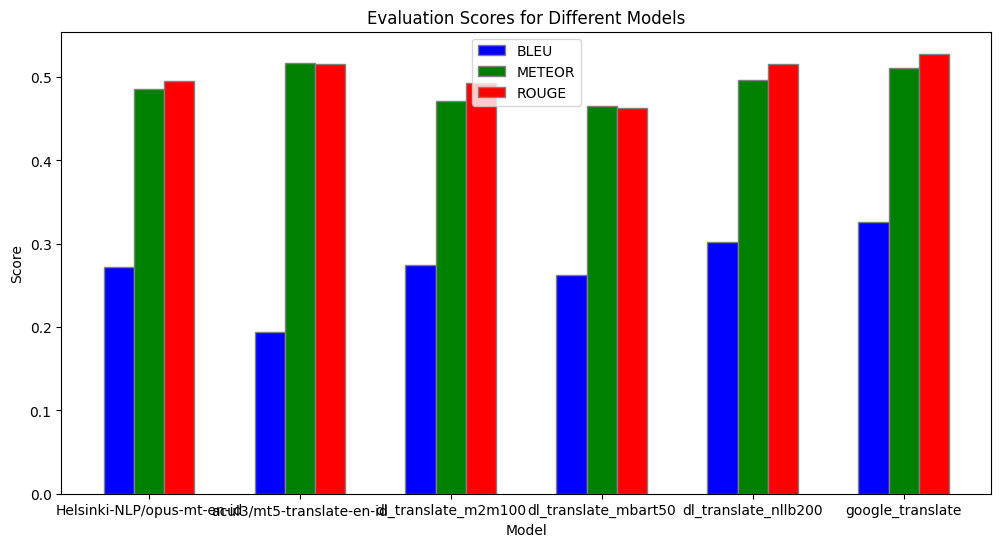

In [12]:
# Plot the scores in a grouped bar chart
fig, ax = plt.subplots(figsize=(12, 6))

# Set the width of each bar
bar_width = 0.2

# Set positions of the bars on the x-axis
r1 = np.arange(len(df_eval))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Plotting the bars
ax.bar(r1, df_eval['bleu_score'], color='blue', width=bar_width, edgecolor='grey', label='BLEU')
ax.bar(r2, df_eval['meteor_score'], color='green', width=bar_width, edgecolor='grey', label='METEOR')
ax.bar(r3, df_eval['rouge_score'], color='red', width=bar_width, edgecolor='grey', label='ROUGE')

# Add labels and title
ax.set_xlabel('Model')
ax.set_ylabel('Score')
ax.set_title('Evaluation Scores for Different Models')
ax.set_xticks([r + bar_width for r in range(len(df_eval))])
ax.set_xticklabels(df_eval['model'])
ax.legend()

# Show the plot
plt.show()

In [13]:
df_eval

,model,bleu_score,rouge_score,meteor_score
0,Helsinki-NLP/opus-mt-en-id,0.272395,0.495036,0.485566
1,acul3/mt5-translate-en-id,0.193364,0.515636,0.517343
2,dl_translate_m2m100,0.274387,0.492205,0.471234
3,dl_translate_mbart50,0.262329,0.462675,0.464616
4,dl_translate_nllb200,0.302145,0.515315,0.496324
5,google_translate,0.325933,0.528075,0.510400


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
